# Controlling a rotating Gaussian bump

* Let the activity go around the network for one period
* Compare the average neural spike trace to the ideal
* See how this varies as the input is reduced
* Repeat for more periods
* (later) use feedback to control the activity

In [2]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
import bindsnet.analysis.plotting
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.rc('figure', figsize=(12.0, 8.0))

In [3]:
def wrap_half_period(x: torch.Tensor, period: int):
	return (x + period//2) % period - period//2

def circ_norm_unnormalised(x: torch.Tensor, mean: torch.Tensor, stdev: float, wrap: int):
	return torch.exp(-wrap_half_period(x - mean, wrap)**2 / 2/stdev**2)

def get_rotating_gaussian(time: int, neurons: int, bump_speed: int, stdev: float):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(neurons))
	return circ_norm_unnormalised(x, (t*bump_speed) % neurons, stdev, neurons)

def convert_to_spikes(x: torch.Tensor, noise_ratio: float=0.0):
	return torch.rand_like(x) < (noise_ratio*torch.rand_like(x) + (1.0-noise_ratio)*(x / x.max()))

def sum_by_index(data: torch.Tensor, indices: torch.Tensor):
	return torch.zeros(indices.max().numpy()+1).index_add(0,indices.flatten(),data.flatten().float())

def roll_tensor_rows(tensor, roll_amounts):
	tensor_rolled = tensor[:, [*range(tensor.shape[1]),*range(tensor.shape[1]-1)]].clone()
	stride_0, stride_1 = tensor_rolled.stride()
	num_cols = tensor.shape[1]
	result = torch.as_strided(tensor_rolled, (*tensor.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[torch.arange(tensor.shape[0]), (num_cols-roll_amounts) % num_cols]

def get_time_periodic_profile(data: torch.Tensor, bump_speed: int):
	'''
	Return the average periodic spiking profile for the network (shifted so the centre angle is in the middle)

	:param data: Spiking output of the network [time*neurons]
	:param bump_speed: How many neurons the neural activity moves per timestep
	'''
	neurons = data.shape[1]
	shifts = -torch.arange(neurons) // bump_speed
	period = neurons // bump_speed
	stack = torch.roll(torch.vstack(torch.split(roll_tensor_rows(data.T, shifts), period, dim=1)), period//2)
	return stack.mean(dim=0), stack.var(dim=0).sqrt()

def get_weight_periodic_profile(weights: torch.Tensor):
	'''
	Return the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.mean(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0), neurons//2)

Create the input for the network

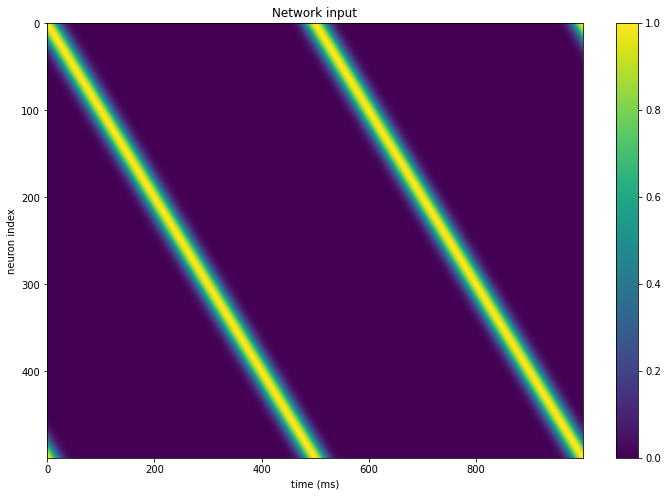

In [4]:
time = 1000
num_neurons = 500
bump_speed = 1
period = num_neurons // bump_speed

input_voltage = get_rotating_gaussian(time, num_neurons, bump_speed, num_neurons//30)
input_spikes = input_voltage
input_spikes -= input_spikes.min()
input_spikes /= input_spikes.max()

plt.imshow(input_spikes.T)
plt.axis('auto')
plt.title('Network input')
plt.ylabel('neuron index')
plt.xlabel('time (ms)')
plt.colorbar()
plt.show()

Create the network of LIF neurons with homeostatic+STDP plasticity. Weights can now be negative - otherwise the firing could explode

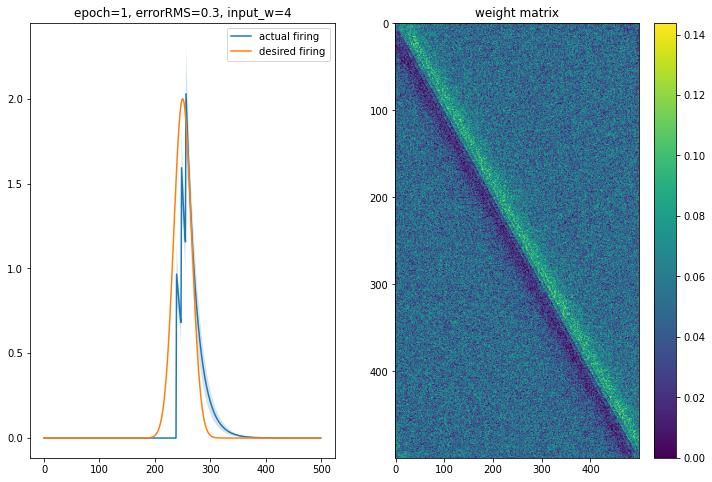

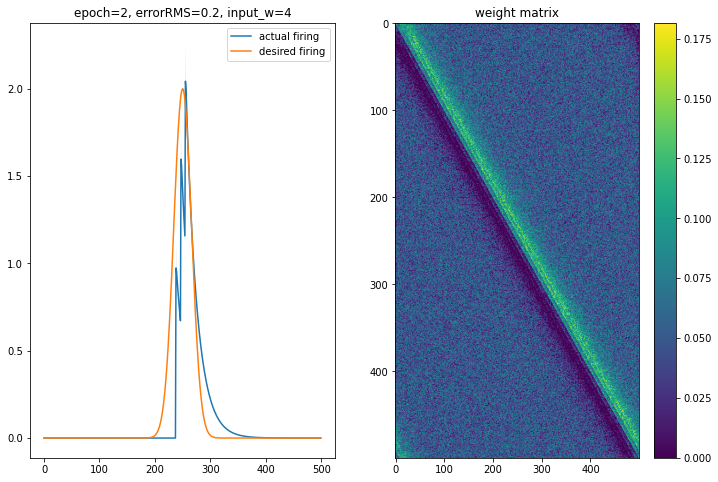

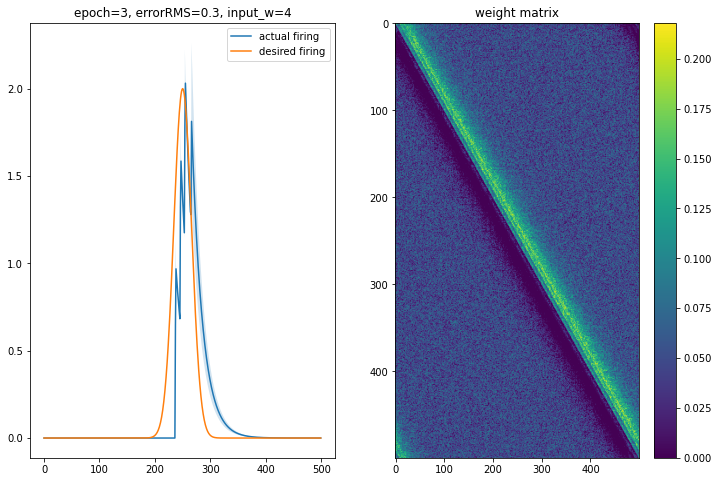

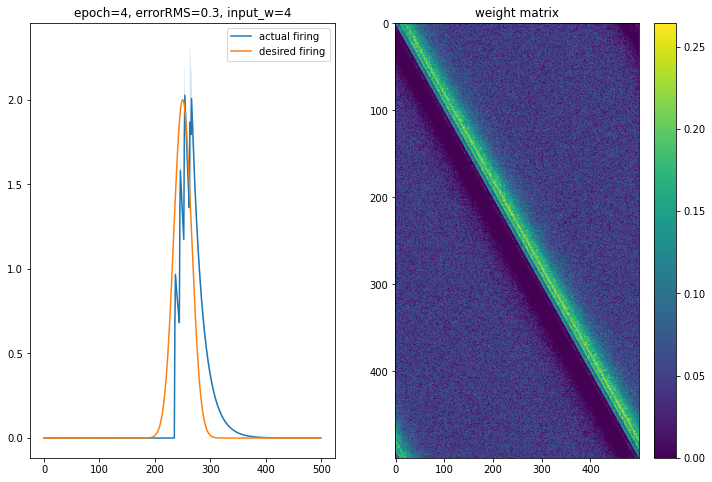

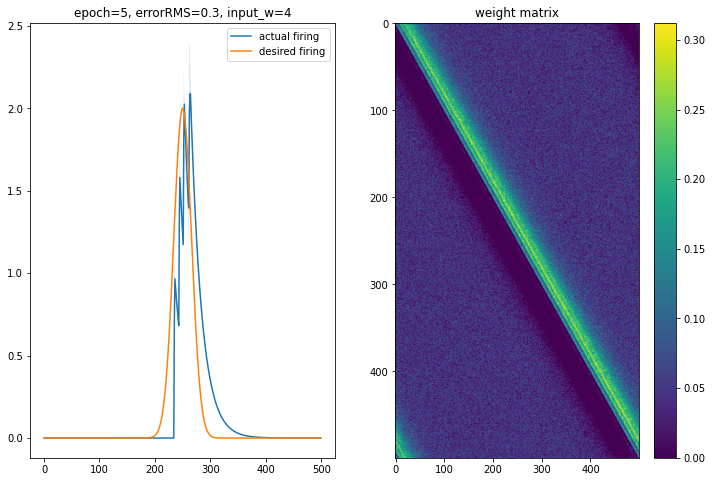

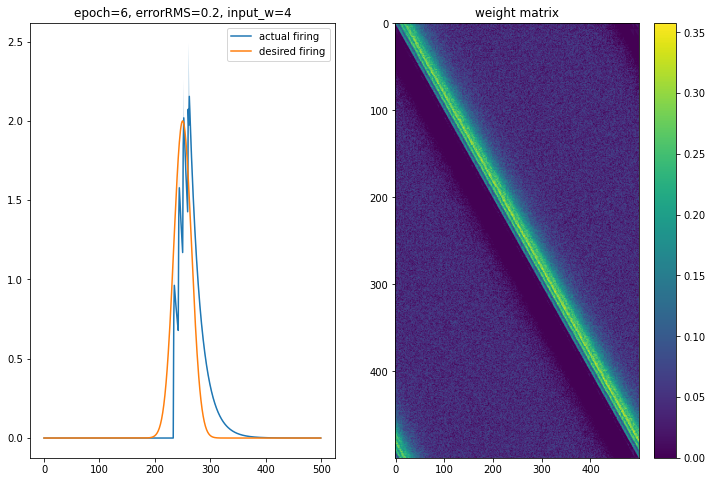

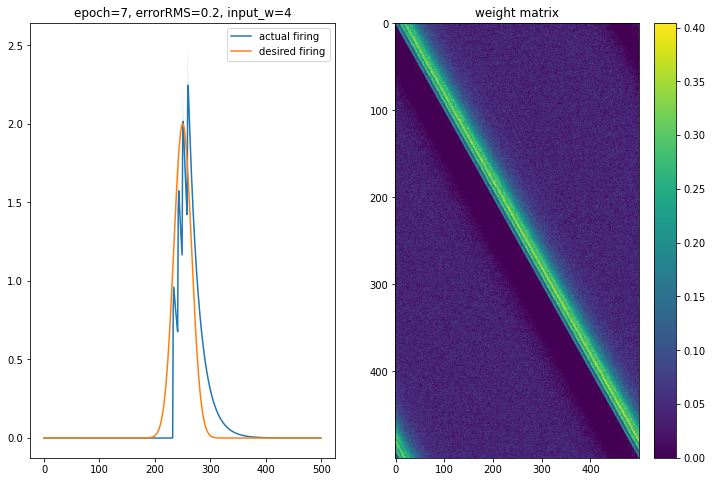

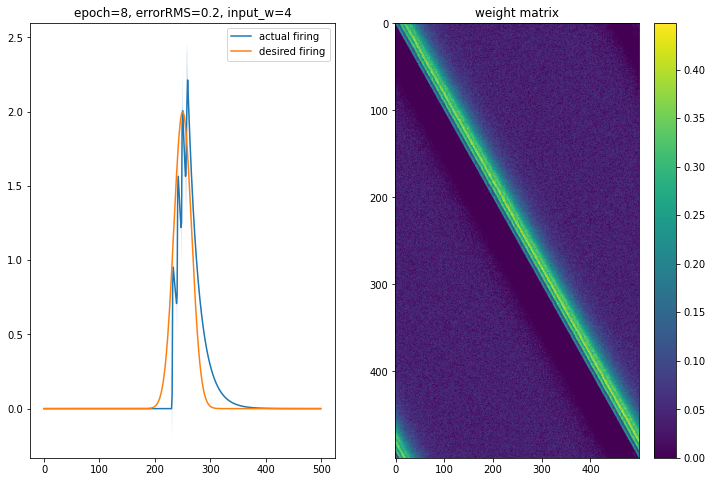

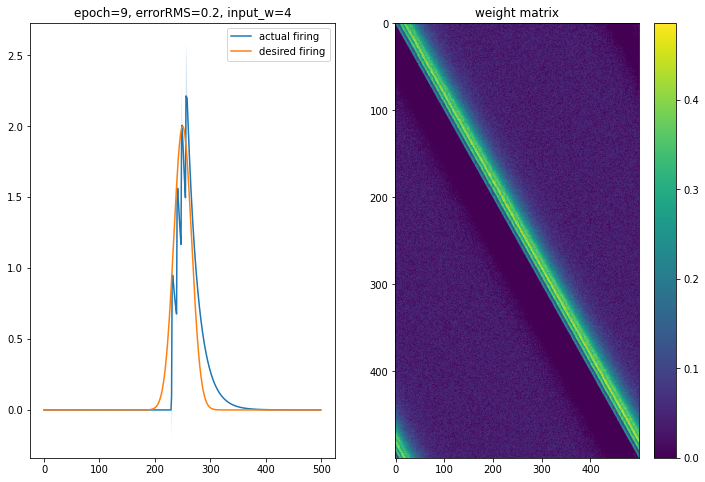

In [5]:
def set_learning_rates(connection, nu, gamma):
	connection.update_rule.nu = torch.Tensor([nu,nu])
	connection.update_rule.gamma = gamma

network = Network()

# Create and add input, output layers.
lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

network.add_layer(layer=lif_layer, name='LIF')

initial_weights = 0.1 * (torch.rand((lif_layer.n,lif_layer.n)))
initial_weights_copy = initial_weights.clone()
recurrent_connection = Connection(
    source=lif_layer,
    target=lif_layer,
	update_rule = HomeostaticSTDP,
	nu=1e-2,
	gamma = 1e-5,
	wmin=0,
    w=initial_weights
)
network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')
inhibitory_connection = Connection(
	source=lif_layer,
    target=lif_layer,
	update_rule = HomeostaticSTDP,
	nu=0,
	gamma = 0,
    w = -0.05 * torch.ones((lif_layer.n,lif_layer.n)),
)
network.add_connection(connection=inhibitory_connection, source='LIF', target='LIF')

# Create and add monitors for spikes, voltages, and short term and long term firing rate traces
monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r', 'x'))
network.add_monitor(monitor=monitor, name='LIF_monitor')

input_weight = 4
epoch_length = period
epoch_input = input_spikes[:epoch_length,:]

def plot_epoch_figure(trace, input, weights):
	trace_profile, tpv = get_time_periodic_profile(trace.squeeze(), bump_speed)
	input_profile, ipv = get_time_periodic_profile(2*input.squeeze(), bump_speed)
	diff = input_profile - trace_profile
	RMS = torch.sqrt(torch.mean(diff**2))

	fig,axs = plt.subplots(1,2)
	axs[0].plot(trace_profile, label='actual firing')
	axs[0].fill_between(torch.arange(num_neurons), trace_profile-tpv, trace_profile+tpv, alpha=0.2)
	axs[0].plot(input_profile, label='desired firing')
	axs[0].fill_between(torch.arange(num_neurons), input_profile-ipv, input_profile+ipv, alpha=0.2)
	# axs[0].plot(diff, label='error')
	axs[0].legend()
	img = axs[1].imshow(weights)
	axs[0].set_title(f'epoch={epoch}, errorRMS={RMS:.1f}, input_w={input_weight}')
	axs[1].set_title('weight matrix')
	plt.colorbar(img)
	plt.axis('auto')
	plt.show()

	return RMS


network.run(inputs={'LIF': input_weight*epoch_input}, time=epoch_length)
for epoch in range(1,10):
	trace = monitor.get('x')
	# spike = monitor.get('s')
	error = plot_epoch_figure(trace, epoch_input, recurrent_connection.w)
	
	# decrease the input weight over time
	# input_weight *= 0.9
	# recurrent_connection.w.data /= 0.9
	network.run(inputs={'LIF': input_weight*epoch_input}, time=epoch_length)

# Retrieve data from monitors for analysis
spikes = monitor.get('s')
voltages = monitor.get('v')
rates = monitor.get('r')
# traces = monitor.get('x')


Network spiking - good for the first period, then gets quite noisy, then clears up, then dies once the weight drops too low

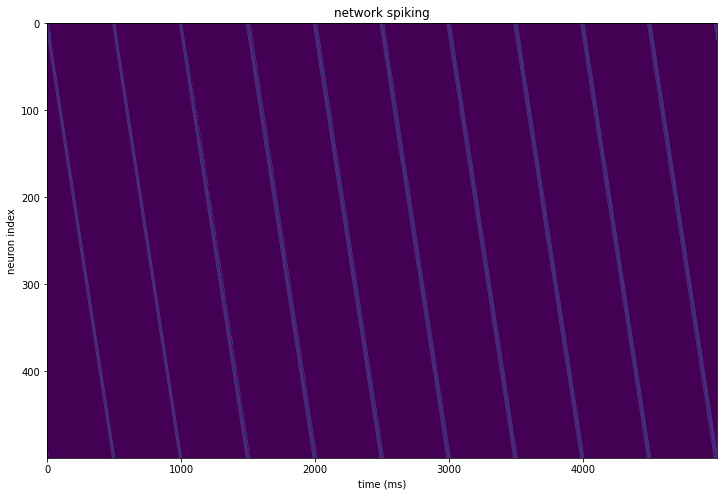

In [6]:
plt.imshow(spikes.squeeze().T)
plt.axis('auto')
plt.xlabel('time (ms)')
plt.ylabel('neuron index')
plt.title('network spiking')
plt.show()

The firing rate trace is dropping over time as the input does - after 2.6 s there is no more firing - exponential decay of firing rate trace

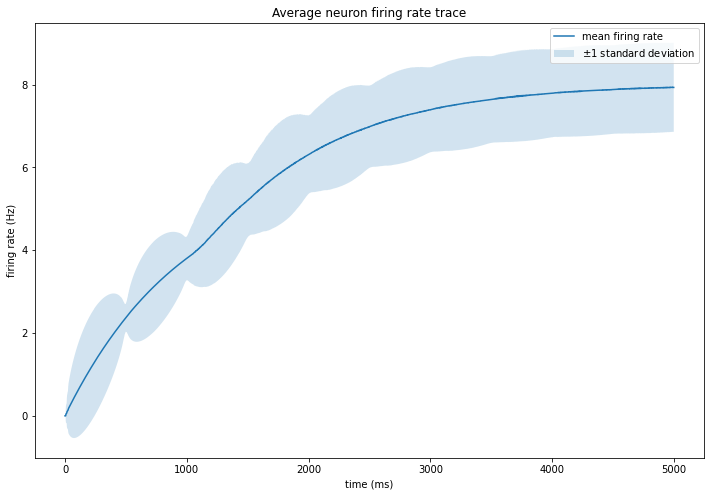

In [7]:
avg = rates.squeeze().mean(dim=1)
stdev = torch.sqrt(rates.squeeze().var(dim=1))
plt.plot(avg)
plt.fill_between(torch.arange(avg.shape[0]), avg-stdev, avg+stdev, alpha=0.2)
plt.legend(['mean firing rate','$\\pm1$ standard deviation'])
plt.title('Average neuron firing rate trace')
plt.xlabel('time (ms)')
plt.ylabel('firing rate (Hz)')
plt.show()